Andrian Danar Perdana
23/513040/PA/21917
Computer Vision KOM

Import Libraries

In [141]:
import os  # For interacting with the operating system, such as file and directory operations
import cv2  # OpenCV library for image processing
import numpy as np  # For numerical operations and handling arrays
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
import matplotlib.pyplot as plt  # For plotting and visualizing data


Load Image and Labels

In [142]:
def load_image(image_path):
    # Read the image from the given path
    image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if image is None:
        print('Error: Could not load image.')
        return None, None
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Return the original image and its grayscale version
    return image, gray

In [143]:
dataset_dir = 'images2'  # Directory containing the dataset of images
images = []  # List to store grayscale images
labels = []  # List to store corresponding labels for the images

# Walk through the dataset directory
for root, dirs, files in os.walk(dataset_dir):
    if len(files) == 0:  # Skip directories with no files
        continue
    for f in files:  # Iterate through each file in the directory
        _, image = load_image(os.path.join(root, f))  # Load the image and its grayscale version
        if image is None:  # Skip if the image could not be loaded
            continue
        images.append(image)  # Append the grayscale image to the list
        labels.append(root.split('/')[-1])  # Append the label (last part of the directory path)

Face Detection

In [144]:
# Load the pre-trained Haar Cascade classifier for face detection
# The classifier is stored in OpenCV's data directory
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [145]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    """
    Detect faces in a grayscale image using the Haar Cascade classifier.

    Parameters:
    - image_gray: Grayscale image in which to detect faces.
    - scale_factor: Parameter specifying how much the image size is reduced at each image scale.
    - min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it.
    - min_size: Minimum possible object size. Objects smaller than this are ignored.

    Returns:
    - faces: A list of rectangles where faces were detected. Each rectangle is represented as (x, y, w, h).
    """
    faces = face_cascade.detectMultiScale(
        image_gray,  # Input grayscale image
        scaleFactor=scale_factor,  # Scale factor for image resizing
        minNeighbors=min_neighbors,  # Minimum neighbors for a rectangle to be considered a face
        minSize=min_size  # Minimum size of detected faces
    )
    return faces  # Return the list of detected faces

In [146]:
def crop_faces(image_gray, faces, return_all=False):
    """
    Crop faces from a grayscale image based on detected face coordinates.

    Parameters:
    - image_gray: Grayscale image from which faces are to be cropped.
    - faces: List of rectangles where faces were detected. Each rectangle is represented as (x, y, w, h).
    - return_all: If True, crop all detected faces. If False, crop only the largest face.

    Returns:
    - cropped_faces: List of cropped face images.
    - selected_faces: List of rectangles corresponding to the cropped faces.
    """
    cropped_faces = []  # List to store cropped face images
    selected_faces = []  # List to store rectangles of selected faces

    # Check if any faces were detected
    if len(faces) > 0:
        if return_all:
            # Crop all detected faces
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))  # Add face rectangle to the list
                cropped_faces.append(image_gray[y:y+h, x:x+w])  # Crop the face from the image
        else:
            # Crop only the largest face (based on area)
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])  # Find the largest face
            selected_faces.append((x, y, w, h))  # Add the largest face rectangle to the list
            cropped_faces.append(image_gray[y:y+h, x:x+w])  # Crop the largest face from the image

    return cropped_faces, selected_faces  # Return the cropped faces and their rectangles

Eigenface Implementation

In [147]:
#Resize and flatten the cropped face images
face_size = (128, 128)
def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

In [148]:
# Split the dataset into training and testing sets
X = []
y = []
for image, label in zip(images, labels): # Iterate through images and labels
    faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)
        y.append(label)
    
X = np.array(X)
y = np.array(y)

In [149]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y) 
# Stratify to maintain class distribution

In [150]:
# Mean centering
from sklearn.base import BaseEstimator, TransformerMixin
class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self
    def transform(self, X):
        return X - self.mean_face   

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# Create a pipeline for the Eigenface implementation
# Step 1: Mean centering to subtract the mean face from all images
# Step 2: PCA for dimensionality reduction and feature extraction
# Step 3: SVM classifier with a linear kernel for face classification
pipe = Pipeline([
    ('centering', MeanCentering()),  # Mean centering step
    ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),  # PCA step
    ('svc', SVC(kernel='linear', random_state=177))  # SVM classifier step
])

In [152]:
# Train the pipeline on the training data
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# Print the classification report to evaluate the model's performance
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

images2\Andrian       0.67      1.00      0.80         2
  images2\Argya       1.00      0.67      0.80         3
 images2\Daniel       0.67      0.67      0.67         3

       accuracy                           0.75         8
      macro avg       0.78      0.78      0.76         8
   weighted avg       0.79      0.75      0.75         8



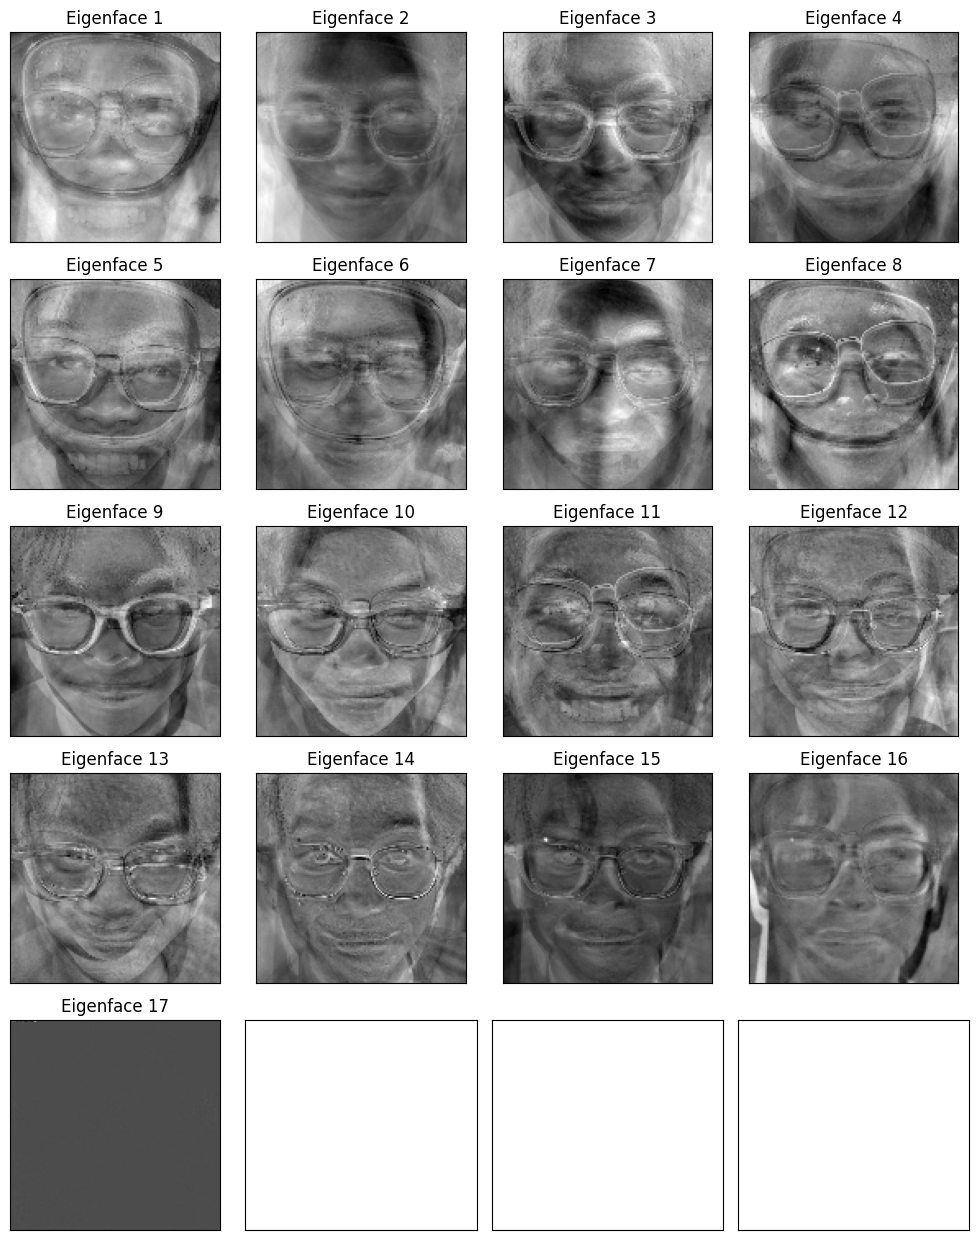

In [153]:
# Visualize the first few eigenfaces
n_components = len(pipe[1].components_)
ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})
eigenfaces = pipe[1].components_.reshape((n_components,X_train.shape[1]))
for i, ax in enumerate(axes.flat[:n_components]):
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

In [154]:
# Save the trained model to a file for later use
import pickle
with open('eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [155]:
# Combine all methods into a single function for easy use
def get_eigenface_score(X):
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores

In [156]:
def eigenface_prediction(image_gray):
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)
    if len(cropped_faces) == 0:
        return 'No face detected.'
    X_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        X_face.append(face_flattened)
    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)
    return scores, labels, selected_faces

In [ ]:
def draw_text(image, label, score, font=cv2.FONT_HERSHEY_SIMPLEX, pos=(0, 0), font_scale=0.6, font_thickness=2, text_color=(0, 0, 0), text_color_bg=(0, 255, 0)):
    """
    Draws a label and score on an image at a specified position.

    Parameters:
    - image: The image on which to draw the text.
    - label: The label text to display.
    - score: The score value to display.
    - font: The font type for the text (default is cv2.FONT_HERSHEY_SIMPLEX).
    - pos: The position (x, y) where the text will be drawn.
    - font_scale: The scale of the font.
    - font_thickness: The thickness of the font.
    - text_color: The color of the text (default is black).
    - text_color_bg: The background color for the text (default is green).

    Returns:
    - None (modifies the image in place).
    """
    x, y = pos  # Extract the x and y coordinates from the position
    score_text = f'Score: {score:.2f}'  # Format the score text
    # Get the size of the score text
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
    # Get the size of the label text
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
    # Draw a filled rectangle as the background for the text
    cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
    # Draw the label text on the image
    cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
    # Draw the score text on the image
    cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

In [ ]:
def draw_result(image, scores, labels, coords):
    """
    Draws rectangles and labels with scores on the detected faces in an image.

    Parameters:
    - image: The original image on which to draw the results.
    - scores: List of confidence scores for each detected face.
    - labels: List of predicted labels for each detected face.
    - coords: List of coordinates (x, y, w, h) for each detected face.

    Returns:
    - result_image: The image with rectangles, labels, and scores drawn on it.
    """
    result_image = image.copy()  # Create a copy of the original image to avoid modifying it
    for (x, y, w, h), label, score in zip(coords, labels, scores):
        # Draw a rectangle around the detected face
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Draw the label and score on the image
        draw_text(result_image, label, score, pos=(x, y))
    return result_image  # Return the modified image with the results

Assignment:

In [159]:
import cv2
import numpy as np
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

# --- Define any custom transformers used in the pipeline ---
class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self

    def transform(self, X):
        return X - self.mean_face

# --- Load the Haar Cascade face detector ---
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# --- Load the trained pipeline (update filename if needed) ---
pipeline = joblib.load("eigenface_pipeline.pkl")  # Or "eigenface_pipeline.pkl" if using that one

# --- Function to detect faces ---
def detect_faces(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    return faces, gray

# --- Function to predict label for a face ---
def predict_label(face_gray):
    face_resized = cv2.resize(face_gray, (128, 128))
    face_flattened = face_resized.flatten().reshape(1, -1)
    label = pipeline.predict(face_flattened)[0]
    return label

# --- Initialize webcam ---
cap = cv2.VideoCapture(0)
print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    faces, gray = detect_faces(frame)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        label = predict_label(face)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow("Eigenface Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Press 'q' to quit.
